**NFL Challange**


# Import Modules and Data

In [117]:
import pandas as pd
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
from sklearn.impute import SimpleImputer
from geopy.geocoders import Nominatim
pd.options.mode.chained_assignment = None  
%matplotlib inline
import mpl_toolkits
import matplotlib.pylab as plt
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn import preprocessing as prep
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression, Ridge, SGDRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit, StratifiedKFold
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.svm import SVC, SVR
from sklearn.utils import check_array
from sklearn.neighbors import KNeighborsClassifier
import regex as re
#from sklearn_pandas import CategoricalImputer
from time import time
import warnings
import json
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse, stats
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


Read the datasets into a utf-8 encoded dataframe 

In [132]:
nfl_stadiums=pd.read_csv("../nfl-scores-and-betting-data/nfl_stadiums.csv",encoding = "utf-8")
nfl_teams=pd.read_csv("../nfl-scores-and-betting-data/nfl_teams.csv",encoding = "utf-8")
nfl_scores=pd.read_csv("../nfl-scores-and-betting-data/spreadspoke_scores.csv",encoding = "utf-8")

## Functions

The cell below contains various functions that will be required in this project

In [133]:
def pct(x):
    return round(100*x,1)
def count_null(df,column): # count the number of null values in a dataframe
    try:
        for x in column:
            null=sum(pd.isnull(df[x]))
            print(x,null)
    except Exception:
            pass
class DataFrameSelector(BaseEstimator, TransformerMixin): # Select attributes of a dataframe
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
class CategoricalEncoder(BaseEstimator, TransformerMixin): #Encode categorical features of the dataframe 
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out
def ttest(control, treatment): #perform a ttest statistic of the experiment
    #paired t-test; two-tailed p-value      A   ,    B
    (t_score, p_value) = stats.ttest_rel(control, treatment)

    if p_value > 0.05/2:  #Two sided 
        print('There is no significant difference between the two machine learning pipelines (Accept H0)')
    else:
        print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
        if t_score > 0.0: #in the case of regression lower RMSE is better; A is lower 
            print('Machine learning pipeline A is better than B')
        else:
            print('Machine learning pipeline B is better than A')
    return p_value

# Fix Nulls

In [134]:
# Create a list of all the columns in each dataset
column_teams=list(nfl_teams.columns)
column_scores=list(nfl_scores.columns)
column_stadiums=list(nfl_stadiums.columns)

In [135]:
#What the scores table looks like
nfl_scores.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_detail,weather_temperature,weather_wind_mph,weather_humidity,score_home,score_away,stadium_neutral,schedule_playoff
0,9/2/1966,1966,1,Miami Dolphins,Oakland Raiders,Orange Bowl,NaN,NaN,NaN,NaN,83.0,6.0,71,14.0,23.0,False,False
1,9/3/1966,1966,1,Houston Oilers,Denver Broncos,Rice Stadium,NaN,NaN,NaN,NaN,81.0,7.0,70,45.0,7.0,False,False
2,9/4/1966,1966,1,San Diego Chargers,Buffalo Bills,Balboa Stadium,NaN,NaN,NaN,NaN,70.0,7.0,82,27.0,7.0,False,False
3,9/9/1966,1966,2,Miami Dolphins,New York Jets,Orange Bowl,NaN,NaN,NaN,NaN,82.0,11.0,78,14.0,19.0,False,False
4,9/10/1966,1966,1,Green Bay Packers,Baltimore Colts,Lambeau Field,NaN,NaN,NaN,64 degrees- humidity 62%- wind 8 mph,64.0,8.0,62,24.0,3.0,False,False


## Nulls for NFL Scores

**Actions in this Section**
* Convert the date to a datetime format.
* Drop unceccary rows where nulls exists.
* Use only rows where games happened after 1980 due to a lot of nulls before 1980.

In [136]:
#Current Nulls
count_null(nfl_scores,column_scores)

schedule_date 0
schedule_season 0
schedule_week 0
team_home 0
team_away 0
stadium 0
team_favorite_id 2601
spread_favorite 2601
over_under_line 2611
weather_detail 7930
weather_temperature 724
weather_wind_mph 724
weather_humidity 4013
score_home 135
score_away 135
stadium_neutral 0
schedule_playoff 0


In [137]:
#Clean the scores dataset and drop null values
nfl_scores["schedule_date"]=pd.to_datetime(nfl_scores["schedule_date"])
nfl_scores.dropna(subset=["score_home","over_under_line","weather_temperature","weather_wind_mph"], inplace=True)
nfl_scores=nfl_scores[nfl_scores['schedule_date'].dt.year >= 1980]

In [138]:
nfl_scores.drop(["weather_humidity","weather_detail","schedule_playoff"], axis=1,inplace=True)

In [139]:
#nfl_scores.loc[(nfl_scores.schedule_week == '18'), 'schedule_week'] = '18'
nfl_scores.loc[(nfl_scores.schedule_week == 'Wildcard') | (nfl_scores.schedule_week == 'WildCard'), 'schedule_week'] = '18'
nfl_scores.loc[(nfl_scores.schedule_week == 'Division'), 'schedule_week'] = '19'
nfl_scores.loc[(nfl_scores.schedule_week == 'Conference'), 'schedule_week'] = '20'
nfl_scores.loc[(nfl_scores.schedule_week == 'Superbowl') | (nfl_scores.schedule_week == 'SuperBowl'), 'schedule_week'] = '21'
nfl_scores['schedule_week'] = nfl_scores.schedule_week.astype(int)

In [140]:
count_null(nfl_scores,column_scores)

schedule_date 0
schedule_season 0
schedule_week 0
team_home 0
team_away 0
stadium 0
team_favorite_id 0
spread_favorite 0
over_under_line 0


The output result above shows no null values present in the scores dataset

In [141]:
nfl_scores.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,score_home,score_away,stadium_neutral
2734,1980-09-07,1980,1,Buffalo Bills,Miami Dolphins,Ralph Wilson Stadium,MIA,-3.0,35,64.0,8.0,17.0,7.0,False
2735,1980-09-07,1980,1,Cincinnati Bengals,Tampa Bay Buccaneers,Cinergy Field,TB,-1.0,34,72.0,9.0,12.0,17.0,False
2736,1980-09-07,1980,1,Green Bay Packers,Chicago Bears,Lambeau Field,CHI,-6.0,35,65.0,5.0,12.0,6.0,False
2737,1980-09-07,1980,1,Kansas City Chiefs,Oakland Raiders,Arrowhead Stadium,KC,-3.0,42,82.0,10.0,14.0,27.0,False
2738,1980-09-07,1980,1,Los Angeles Rams,Detroit Lions,Anaheim Stadium,LAR,-9.0,38,66.0,11.0,20.0,41.0,False


## Nulls for NFL Teams

In [142]:
count_null(nfl_teams,column_teams)

team_name 0
team_name_short 0
team_id 0
team_id_pfr 0
team_conference 0
team_division 8
team_conference_pre2002 0
team_division_pre2002 2


Team division and team_division_pre2002 both contain null values

In [144]:
nfl_teams.head()

,team_name,team_name_short,team_id,team_id_pfr,team_conference,team_division,team_conference_pre2002,team_division_pre2002
0,Arizona Cardinals,Cardinals,ARI,CRD,NFC,NFC West,NFC,NFC West
1,Phoenix Cardinals,Cardinals,ARI,CRD,NFC,NaN,NFC,NFC East
2,St. Louis Cardinals,Cardinals,ARI,ARI,NFC,NaN,NFC,NFC East
3,Atlanta Falcons,Falcons,ATL,ATL,NFC,NFC South,NFC,NFC West
4,Baltimore Ravens,Ravens,BAL,RAV,AFC,AFC North,AFC,AFC Central


In [145]:
null_columns=nfl_teams.columns[nfl_teams.isnull().any()]
print(nfl_teams[nfl_teams["team_division_pre2002"].isnull()][null_columns])

   team_division team_division_pre2002
14     AFC South                   NaN
26           NaN                   NaN


## Nulls for NFL Stadiums
**Actions in this Section**
* Fill in nulls of stadium close with 2018 for better visualizations.
* Fill in the NA of the Lat, Long and Elevation with 0's for easy manipulation.
* Drop Stadium Close with nulls
* Drop Unneccesary columns.
* Fill in missing lattitude and Longitude with accurate geopoints.

In [146]:
nfl_stadiums['stadium_close'] = nfl_stadiums['stadium_close'].fillna(2018)
nfl_stadiums['LATITUDE'] = nfl_stadiums['LATITUDE'].fillna(0)
nfl_stadiums['LONGITUDE'] = nfl_stadiums['LONGITUDE'].fillna(0)
nfl_stadiums['ELEVATION'] = nfl_stadiums['ELEVATION'].fillna(0)
nfl_stadiums=nfl_stadiums[(nfl_stadiums['stadium_close'] >= 1980)]
count_null(nfl_stadiums,column_stadiums)

stadium_name 0
stadium_location 0
stadium_open 23
stadium_close 0
stadium_type 7
stadium_address 9
stadium_weather_station_code 10
stadium_weather_type 7
stadium_capacity 58
stadium_surface 45
STATION 44
NAME 44
LATITUDE 0
LONGITUDE 0
ELEVATION 0


In [148]:
print(len(nfl_stadiums))

nfl_stadiums.head(5)

96


,stadium_name,stadium_location,stadium_open,stadium_close,stadium_type,stadium_address,stadium_weather_station_code,stadium_weather_type,stadium_capacity,stadium_surface,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION
0,Alamo Dome,"San Antonio, TX",NaN,2018.0,indoor,"100 Montana St, San Antonio, TX 78203",78203,dome,72000,FieldTurf,NaN,NaN,0.0000,0.0000,0.0
1,Alltel Stadium,"Jacksonville, FL",NaN,2018.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0
2,Alumni Stadium,"Chestnut Hill, MA",NaN,2018.0,outdoor,"Perimeter Rd, Chestnut Hill, MA 02467",2467,cold,NaN,Grass,NaN,NaN,0.0000,0.0000,0.0
3,Anaheim Stadium,"Anaheim, CA",1980.0,1994.0,outdoor,"2000 E Gene Autry Way, Anaheim, CA 92806",92806,warm,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0
4,Arrowhead Stadium,"Kansas City, MO",1972.0,2018.0,outdoor,"1 Arrowhead Dr, Kansas City, MO 64129",64129,cold,"76,416",Grass,US1MOJC0028,"KANSAS CITY 5.1 SE, MO US",39.0692,-94.4871,264.9


In [149]:
#Fills in the Latitude, Longitude and Elevation where it is missing.
geolocator = Nominatim(user_agent="NFL")
for i, row in nfl_stadiums.iterrows():
    try:
        if nfl_stadiums.LATITUDE[i]==0:
            location = geolocator.geocode(nfl_stadiums.stadium_address[i])
            nfl_stadiums.LATITUDE[i]=location.latitude
            nfl_stadiums.LONGITUDE[i]=location.longitude
            nfl_stadiums.ELEVATION[i]=location.altitude
        else:
            pass
    except:
        pass

In [150]:
#drop unnecessary tables
nfl_stadiums.dropna(subset=["stadium_open"], inplace=True)
nfl_stadiums.drop(["NAME","stadium_surface", "stadium_capacity", "STATION","stadium_weather_station_code"], axis=1,inplace=True)

In [151]:
#Fill NA values of the stadiums dataset
nfl_stadiums['stadium_close'] = nfl_stadiums['stadium_close'].fillna(2020)
nfl_stadiums['LATITUDE'] = nfl_stadiums['LATITUDE'].fillna(0)
nfl_stadiums['LONGITUDE'] = nfl_stadiums['LONGITUDE'].fillna(0)
nfl_stadiums['ELEVATION'] = nfl_stadiums['ELEVATION'].fillna(0)
nfl_stadiums=nfl_stadiums[(nfl_stadiums['stadium_close'] >= 1980)]

In [152]:
geolocator = Nominatim(user_agent="NFL")
for i, row in nfl_stadiums.iterrows():
    try:
        if nfl_stadiums.LATITUDE[i]==0:
            location = geolocator.geocode(nfl_stadiums.stadium_address[i])
            nfl_stadiums.LATITUDE[i]=location.latitude
            nfl_stadiums.LONGITUDE[i]=location.longitude
            nfl_stadiums.ELEVATION[i]=location.altitude
        else:
            pass
    except:
        pass
        

In [153]:
count_null(nfl_stadiums,column_stadiums)

stadium_name 0
stadium_location 0
stadium_open 0
stadium_close 0
stadium_type 0
stadium_address 0


# EDA

This section will involve exploratory data analysis of the three datasets 

## EDA for NFL_Scores

In [155]:
nfl_scores.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,score_home,score_away,stadium_neutral
2734,1980-09-07,1980,1,Buffalo Bills,Miami Dolphins,Ralph Wilson Stadium,MIA,-3.0,35,64.0,8.0,17.0,7.0,False
2735,1980-09-07,1980,1,Cincinnati Bengals,Tampa Bay Buccaneers,Cinergy Field,TB,-1.0,34,72.0,9.0,12.0,17.0,False
2736,1980-09-07,1980,1,Green Bay Packers,Chicago Bears,Lambeau Field,CHI,-6.0,35,65.0,5.0,12.0,6.0,False
2737,1980-09-07,1980,1,Kansas City Chiefs,Oakland Raiders,Arrowhead Stadium,KC,-3.0,42,82.0,10.0,14.0,27.0,False
2738,1980-09-07,1980,1,Los Angeles Rams,Detroit Lions,Anaheim Stadium,LAR,-9.0,38,66.0,11.0,20.0,41.0,False


In [156]:
nfl_scores.shape

(9181, 14)

In [157]:
nfl_scores.dtypes

schedule_date          datetime64[ns]
schedule_season                 int64
schedule_week                   int64
team_home                      object
team_away                      object
stadium                        object
team_favorite_id               object
spread_favorite               float64
over_under_line                object
weather_temperature           float64
weather_wind_mph              float64
score_home                    float64
score_away                    float64
stadium_neutral                  bool
dtype: object

In [158]:
nfl_scores['over_under_line'] = nfl_scores['over_under_line'].astype(float)

In [159]:
nfl_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9181 entries, 2734 to 12264
Data columns (total 14 columns):
schedule_date          9181 non-null datetime64[ns]
schedule_season        9181 non-null int64
schedule_week          9181 non-null int64
team_home              9181 non-null object
team_away              9181 non-null object
stadium                9181 non-null object
team_favorite_id       9181 non-null object
spread_favorite        9181 non-null float64
over_under_line        9181 non-null float64
weather_temperature    9181 non-null float64
weather_wind_mph       9181 non-null float64
score_home             9181 non-null float64
score_away             9181 non-null float64
stadium_neutral        9181 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(6), int64(2), object(4)
memory usage: 1013.1+ KB


In [161]:
nfl_scores.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
schedule_season,9181.0,1999.701884,10.993210,1980.0,1990.0,2000.0,2009.0,2018.0
schedule_week,9181.0,8.924191,4.974480,1.0,5.0,9.0,13.0,21.0
spread_favorite,9181.0,-5.348219,3.415997,-26.5,-7.0,-4.5,-3.0,0.0
over_under_line,9181.0,41.823244,4.576730,28.0,38.0,41.5,45.0,63.0
weather_temperature,9181.0,59.752423,15.481616,-6.0,49.0,63.0,72.0,97.0
weather_wind_mph,9181.0,7.389936,5.692980,0.0,2.0,8.0,11.0,40.0
score_home,9181.0,22.561159,10.349465,0.0,16.0,22.0,30.0,62.0
score_away,9181.0,19.880841,10.042576,0.0,13.0,20.0,27.0,59.0


### Change Name mappings

There were some inconsistancies in the data set. For example, the Chicago Bears were referenced by CHI and Chicago Bears. So made all the name callings but the short two or three letter code. 


In [162]:
name_mappings = [('ATL','Atlanta Falcons'),
                 ('BUF', 'Buffalo Bills'),
                 ('JAX','Jacksonville Jaguars'),
                 ('DAL', 'Dallas Cowboys'),
                 ('GB', 'Green Bay Packers'),
                 ('IND','Indianapolis Colts'),
                 ('MIA', 'Miami Dolphins'),
                 ('MIN','Minnesota Vikings'),
                 ('TB', 'Tampa Bay Buccaneers'),
                 ('NYG','New York Giants'),
                 ('OAK', 'Oakland Raiders'),
                 ('BAL','Baltimore Ravens'),
                 ('WAS', 'Washington Redskins'),
                 ('LAR', 'Los Angeles Rams'),
                 ('ARI', 'Arizona Cardinals'),
                 ('CIN', 'Cincinnati Bengals'),
                 ('DEN', 'Denver Broncos'),
                 ('PHI', 'Philadelphia Eagles'),
                 ('LAC','Los Angeles Chargers'),
                 ('CAR','Carolina Panthers'),
                 ('TEN','Tennessee Titans'),
                 ('NYJ', 'New York Jets'),
                 ('CHI', 'Chicago Bears'),
                 ('LAR', 'St. Louis Rams'),
                 ('PIT', 'Pittsburgh Steelers'),
                 ('KC', 'Kansas City Chiefs'),
                 ('LAC', 'San Diego Chargers'),
                 ('NE','New England Patriots'),
                 ('SEA','Seattle Seahawks'),
                 ('NO', 'New Orleans Saints'),
                 ('DET', 'Detroit Lions'),
                 ('SF', 'San Francisco 49ers'),
                 ('CLE', 'Cleveland Browns'),
                 ('HOU', 'Houston Texans'),
                 ('TEN','Houston Oilers'),
                 ('OAK','Los Angeles Raiders'),
                 ('ARI','St. Louis Cardinals'),
                 ('ARI','Phoenix Cardinals'),
                 ('IND','Baltimore Colts'),
                 ('TEN','Tennessee Oilers')]
    
for mapping in name_mappings:
    nfl_scores.team_away.replace(mapping[1], mapping[0],inplace=True)
    nfl_scores.team_home.replace(mapping[1], mapping[0],inplace=True)

In later examining our dataset, we noticed an error where DET was listed as playing twice in a single week (shown below). The second instance was actually their week 5 game (instead of two week 4), so we corrected that in place. 

In [163]:
nfl_scores.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,score_home,score_away,stadium_neutral
2734,1980-09-07,1980,1,BUF,MIA,Ralph Wilson Stadium,MIA,-3.0,35.0,64.0,8.0,17.0,7.0,False
2735,1980-09-07,1980,1,CIN,TB,Cinergy Field,TB,-1.0,34.0,72.0,9.0,12.0,17.0,False
2736,1980-09-07,1980,1,GB,CHI,Lambeau Field,CHI,-6.0,35.0,65.0,5.0,12.0,6.0,False
2737,1980-09-07,1980,1,KC,OAK,Arrowhead Stadium,KC,-3.0,42.0,82.0,10.0,14.0,27.0,False
2738,1980-09-07,1980,1,LAR,DET,Anaheim Stadium,LAR,-9.0,38.0,66.0,11.0,20.0,41.0,False


In [164]:
nfl_scores[((nfl_scores['team_home'] == 'DET') | (nfl_scores['team_away'] == 'DET')) & 
           (nfl_scores['schedule_season'] == 1990) & (nfl_scores['schedule_week'] == 4)]

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,score_home,score_away,stadium_neutral
4959,1990-09-30,1990,4,DET,GB,Pontiac Silverdome,DET,-2.5,46.0,72.0,0.0,21.0,24.0,False
4978,1990-10-07,1990,4,MIN,DET,Hubert H. Humphrey Metrodome,MIN,-7.0,43.0,72.0,0.0,27.0,34.0,False


In [165]:
nfl_scores.at[4978, 'schedule_week'] = 5

In [166]:
nfl_scores[((nfl_scores['team_home'] == 'DET') | (nfl_scores['team_away'] == 'DET')) & 
         (nfl_scores['schedule_season'] == 1990) & (nfl_scores['schedule_week'].between(4,5, inclusive = True) )]

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,score_home,score_away,stadium_neutral
4959,1990-09-30,1990,4,DET,GB,Pontiac Silverdome,DET,-2.5,46.0,72.0,0.0,21.0,24.0,False
4978,1990-10-07,1990,5,MIN,DET,Hubert H. Humphrey Metrodome,MIN,-7.0,43.0,72.0,0.0,27.0,34.0,False


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e275d68>,
      dtype=object)

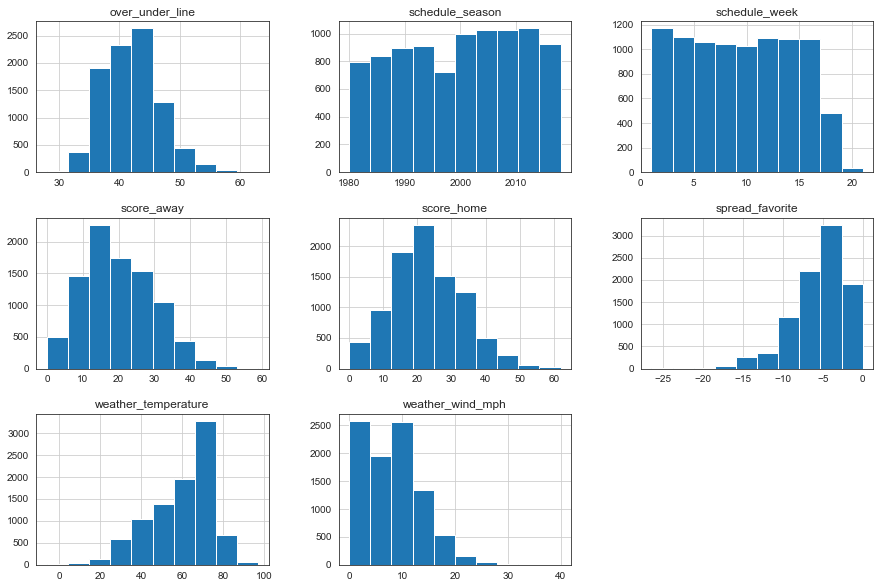

In [70]:
num_nfl_scores = nfl_scores[["schedule_season","schedule_week","spread_favorite","over_under_line",
                            "weather_temperature","weather_wind_mph","score_home","score_away"]]
num_nfl_scores.hist(figsize=(15,10))

In [168]:
#Out of the 8 attributes, over_under_line, score_away, and score_home are somewhat bell-shaped though skewed to the left.

     Compute the correlation the different attributes with relation to the spread_favorite

In [167]:
corr = nfl_scores.corr()
corr['spread_favorite'].sort_values(ascending=False)

spread_favorite        1.000000
score_away             0.125770
weather_temperature    0.066207
stadium_neutral        0.010537
schedule_season       -0.015780
weather_wind_mph      -0.028922
over_under_line       -0.045582
schedule_week         -0.076572
score_home            -0.140107
Name: spread_favorite, dtype: float64

In [170]:
#Score_away and score_home possess the highest correlation based on the output above

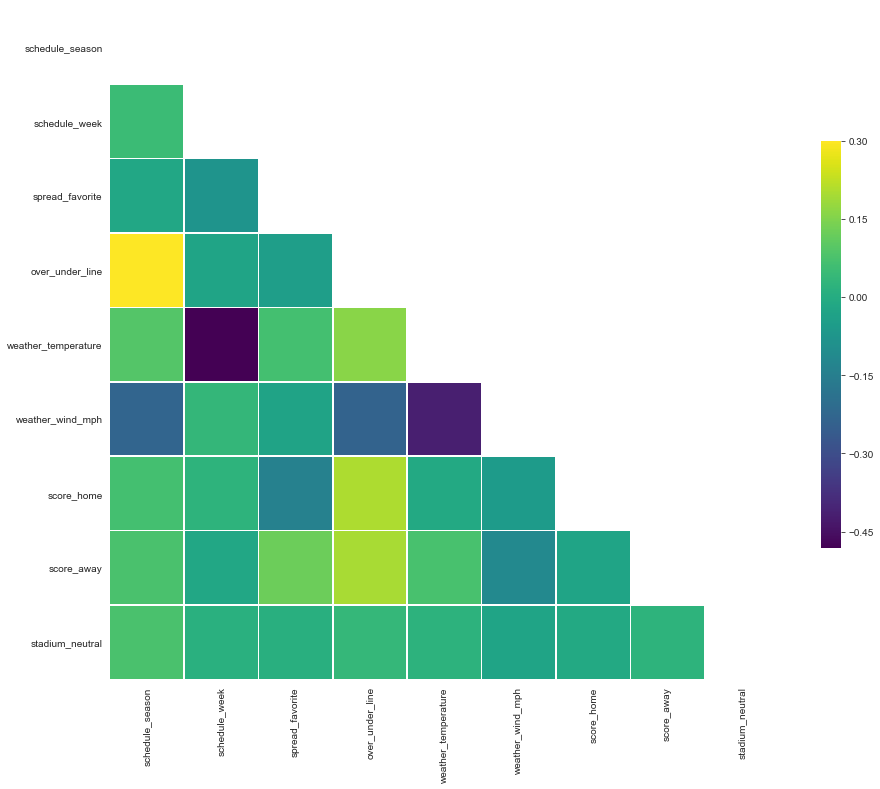

In [72]:
# generate a mask for the lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,15))

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="viridis", vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)


for tick in ax.get_yticklabels():
    tick.set_rotation(0);

### EDA for NFL Teams

#### Find the total number of teams
There are 33 unique teams. 

In [73]:
unique_teams = nfl_teams['team_name_short'].unique()
print('# of Unique Teams (all eras)',len(unique_teams))
unique_teams

# of Unique Teams (all eras) 33


array(['Cardinals', 'Falcons', 'Ravens', 'Bills', 'Panthers', 'Bears',
       'Bengals', 'Browns', 'Cowboys', 'Broncos', 'Lions', 'Packers',
       'Texans', 'Colts', 'Jaguars', 'Chiefs', 'Chargers', 'Rams',
       'Dolphins', 'Vikings', 'Patriots', 'Saints', 'Giants', 'Jets',
       'Raiders', 'Eagles', 'Steelers', 'Seahawks', '49ers', 'Buccaneers',
       'Oilers', 'Titans', 'Redskins'], dtype=object)

#### Find the teams who have moved cities
Seven teams have moved (listed below) with the Cardinals moving the most (3 times)

In [74]:
team_counts = nfl_teams['team_name_short'].value_counts()
moved_teams = team_counts[team_counts>1]

print('# of Moved Teams', len(moved_teams))
moved_teams

# of Moved Teams 7


Cardinals    3
Raiders      2
Chargers     2
Oilers       2
Patriots     2
Rams         2
Colts        2
Name: team_name_short, dtype: int64

#### For those teams that moved cities, find which cities they were associated with. 

In [75]:
all_cities = []

for i in moved_teams.index: 
    full_names = nfl_teams[nfl_teams['team_name_short']==i]['team_name'].tolist()
    cities = [x.replace(i,'') for x in full_names]
    all_cities.append(cities)

pd.DataFrame({'Team':moved_teams.index, 
              'Cities':all_cities})

,Team,Cities
0,Cardinals,"[Arizona , Phoenix , St. Louis ]"
1,Raiders,"[Los Angeles , Oakland ]"
2,Chargers,"[Los Angeles , San Diego ]"
3,Oilers,"[Houston , Tennessee ]"
4,Patriots,"[New England , Boston ]"
5,Rams,"[Los Angeles , St. Louis ]"
6,Colts,"[Baltimore , Indianapolis ]"


#### Which teams are no longer around? 

In [76]:
extinct_teams = nfl_teams.team_name[nfl_teams.team_division.isna()]
extinct_teams

1       Phoenix Cardinals
2     St. Louis Cardinals
15        Baltimore Colts
22         St. Louis Rams
26        Boston Patriots
30    Los Angeles Raiders
37         Houston Oilers
38       Tennessee Oilers
Name: team_name, dtype: object

#### For the teams that are no longer around, which franchises did they become? 

In [77]:
current_team_names = nfl_teams.team_name_short[nfl_teams.team_division.isna()].unique()

nfl_teams.team_name[(nfl_teams.team_name_short.isin(current_team_names)) & (nfl_teams.team_division.notna())]

0        Arizona Cardinals
16      Indianapolis Colts
21        Los Angeles Rams
25    New England Patriots
31         Oakland Raiders
Name: team_name, dtype: object

#### How many teams are there per conference (pre-2002 and now)? 

In [78]:
new_teams = nfl_teams.team_name[nfl_teams.team_division_pre2002.isna()]

for team in new_teams: 
    if team not in extinct_teams.tolist(): 
        print(team)

Houston Texans


#### How many teams are in each division?

In [79]:
curr_div = nfl_teams.team_division.value_counts()
curr_div

AFC West     5
NFC West     4
AFC East     4
NFC East     4
AFC South    4
AFC North    4
NFC North    4
NFC South    4
Name: team_division, dtype: int64

#### How many teams are in each division pre-2002?

In [80]:
pre_2002_div = nfl_teams.team_division_pre2002.value_counts()
pre_2002_div

AFC Central    8
NFC West       7
AFC West       7
AFC East       6
NFC East       6
NFC Central    5
Name: team_division_pre2002, dtype: int64

#### Which NFL teams swtiched divisions?

In [81]:
nfl_teams[nfl_teams.team_division != nfl_teams.team_division_pre2002].dropna()

,team_name,team_name_short,team_id,team_id_pfr,team_conference,team_division,team_conference_pre2002,team_division_pre2002
3,Atlanta Falcons,Falcons,ATL,ATL,NFC,NFC South,NFC,NFC West
4,Baltimore Ravens,Ravens,BAL,RAV,AFC,AFC North,AFC,AFC Central
6,Carolina Panthers,Panthers,CAR,CAR,NFC,NFC South,NFC,NFC West
7,Chicago Bears,Bears,CHI,CHI,NFC,NFC North,NFC,NFC Central
8,Cincinnati Bengals,Bengals,CIN,CIN,AFC,AFC North,AFC,AFC Central
9,Cleveland Browns,Browns,CLE,CLE,AFC,AFC North,AFC,AFC Central
12,Detroit Lions,Lions,DET,DET,NFC,NFC North,NFC,NFC Central
13,Green Bay Packers,Packers,GB,GNB,NFC,NFC North,NFC,NFC Central
16,Indianapolis Colts,Colts,IND,CLT,AFC,AFC South,AFC,AFC East
17,Jacksonville Jaguars,Jaguars,JAX,JAX,AFC,AFC South,AFC,AFC Central


#### How many NFL teams per conference (post-2002)?

In [82]:
nfl_teams.team_conference.value_counts()

AFC    21
NFC    20
Name: team_conference, dtype: int64

#### How many NFL teams per conference (pre-2002)?

In [83]:
nfl_teams.team_conference_pre2002.value_counts()

AFC    22
NFC    19
Name: team_conference_pre2002, dtype: int64

#### Which team switched conferences?

In [84]:
nfl_teams[nfl_teams.team_conference != nfl_teams.team_conference_pre2002].dropna()

,team_name,team_name_short,team_id,team_id_pfr,team_conference,team_division,team_conference_pre2002,team_division_pre2002
34,Seattle Seahawks,Seahawks,SEA,SEA,NFC,NFC West,AFC,AFC West


### EDA for NFL Stadiums

**Life of a Stadium**
* This shows the life of a stadium by how long it has been active
* The types of weather in these stadiums. 
* This shows the map of the united states of where the stadiums are located 

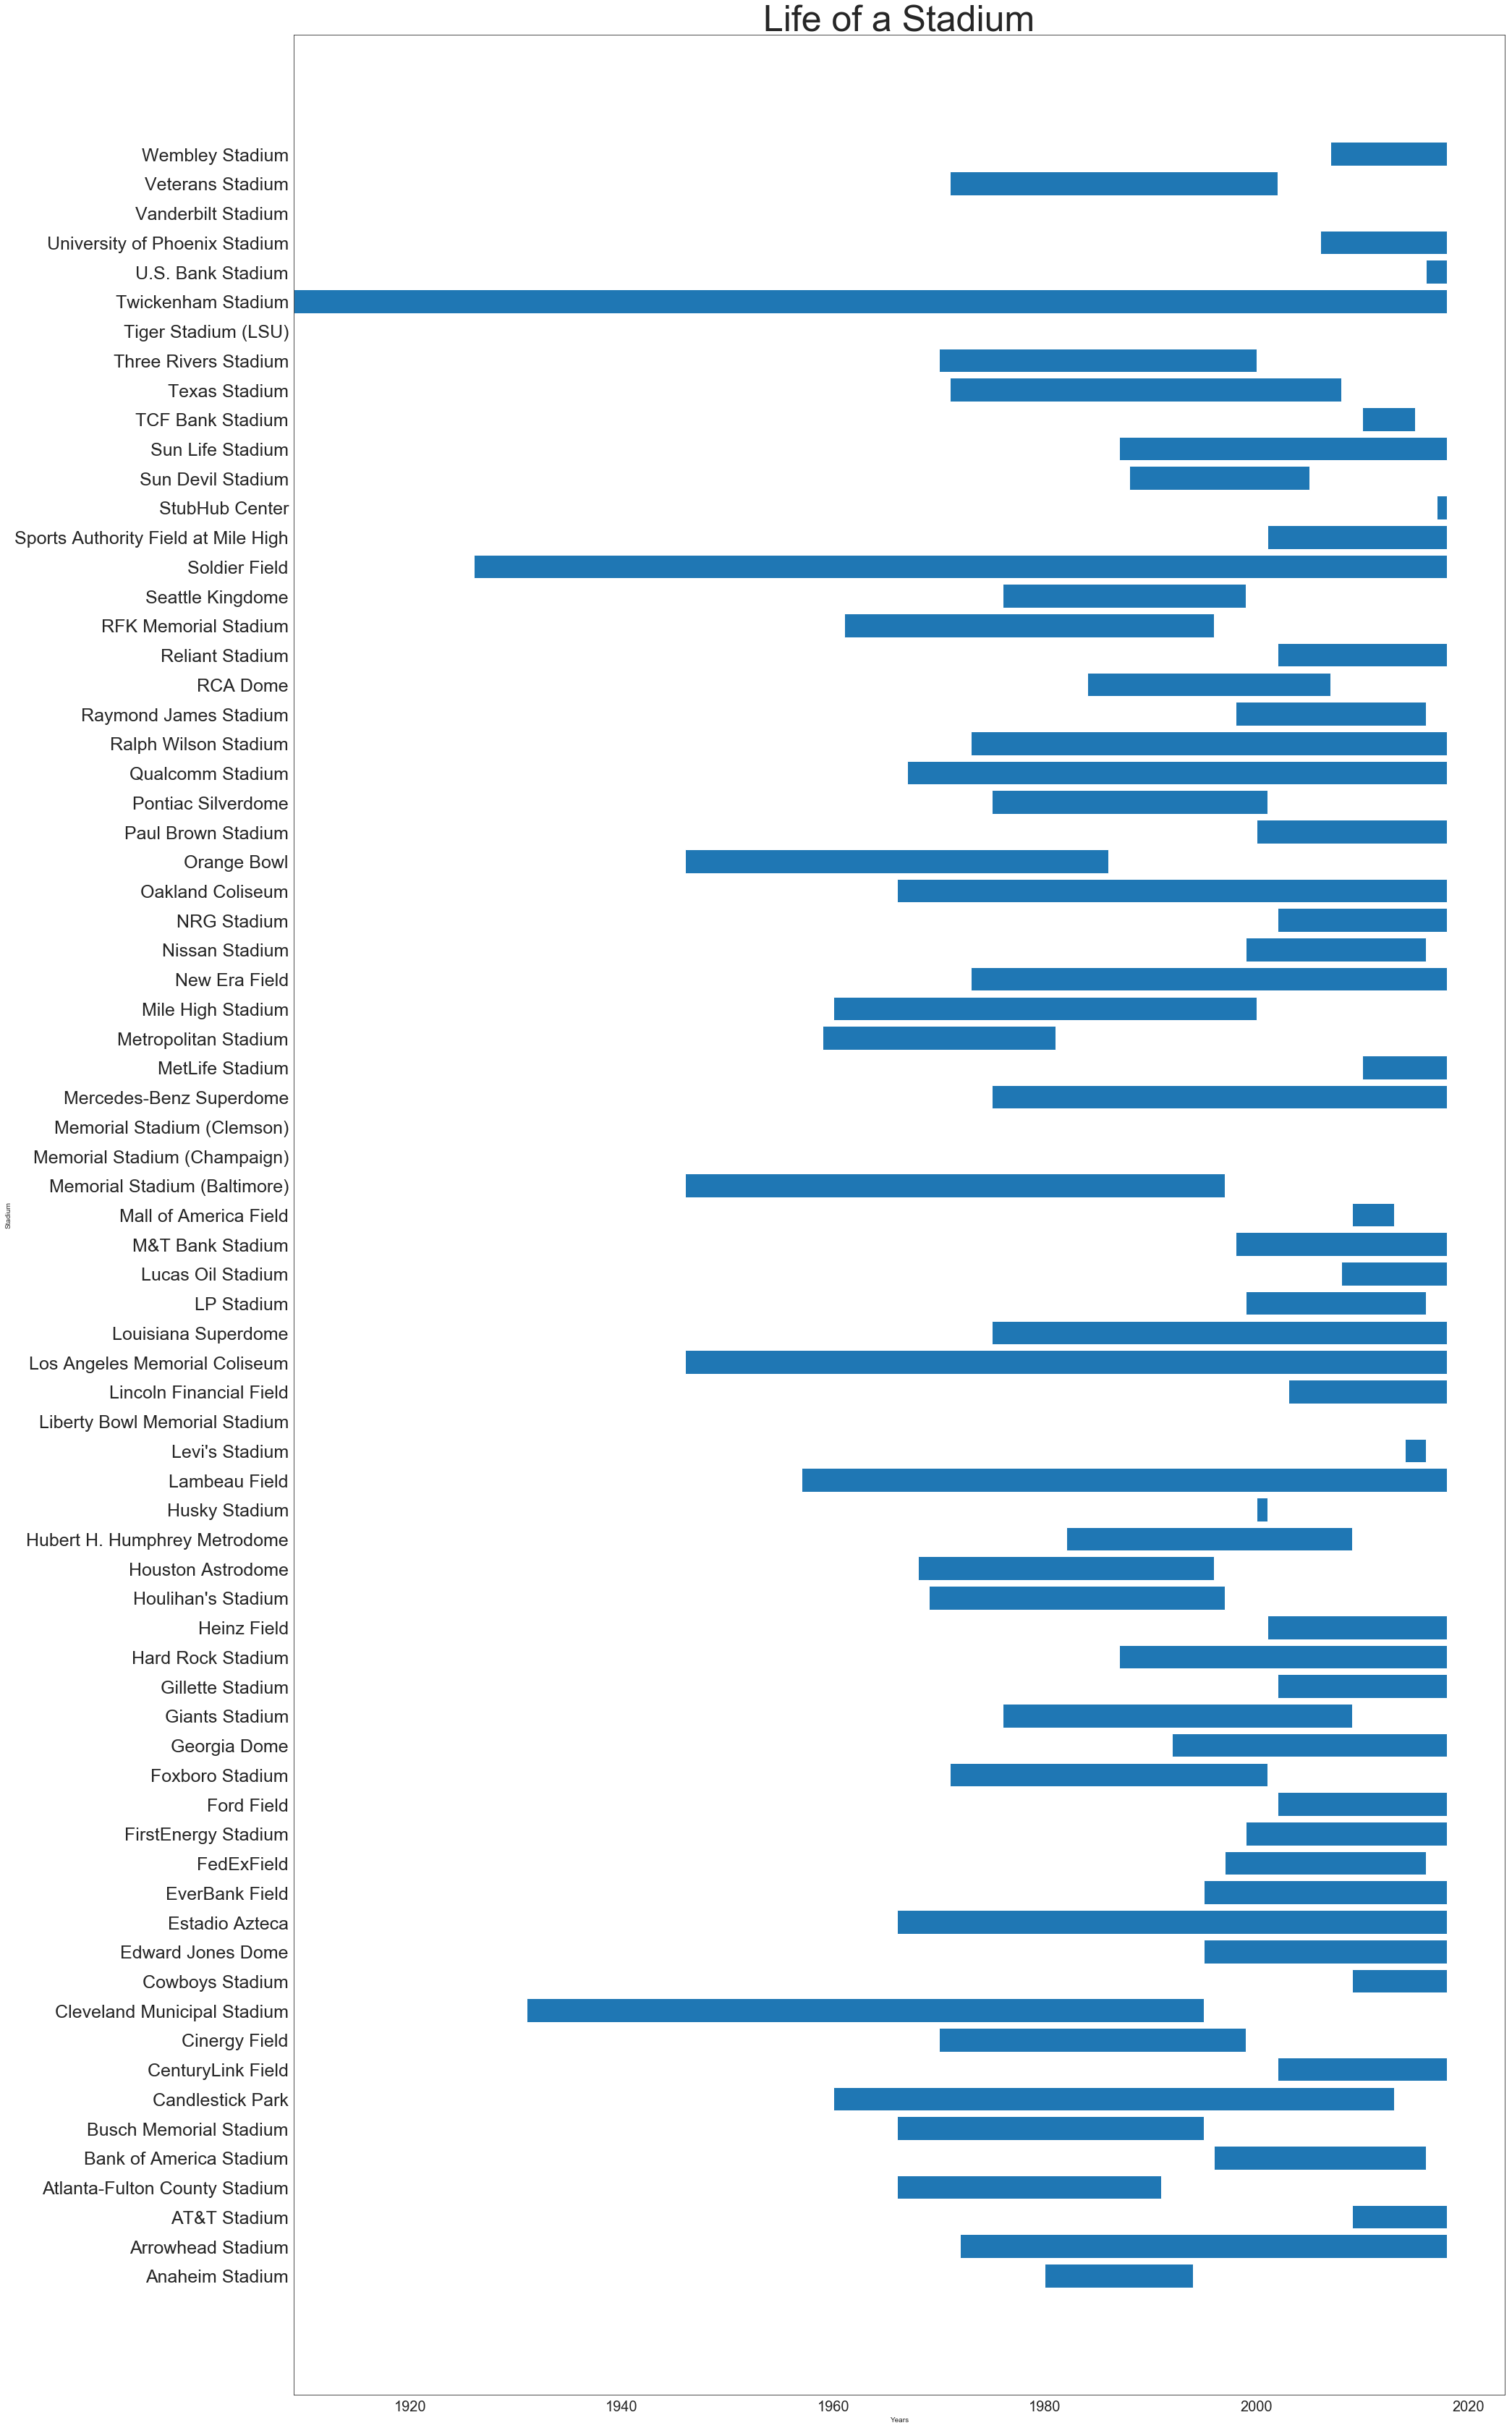

<Figure size 2160x4320 with 0 Axes>

In [171]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 60
plt.rcParams["figure.figsize"] = fig_size
begin = nfl_stadiums.stadium_open.values
end =   nfl_stadiums.stadium_close.values
event = nfl_stadiums.stadium_name.values

plt.barh(range(len(begin)),  end-begin, left=begin)
plt.xticks(fontsize=20)
plt.yticks(range(73), event, fontsize=25)
plt.title("Life of a Stadium", fontsize=50)
plt.xlabel("Years")
plt.ylabel("Stadium")
plt.show()
plt.savefig('LifeofaStadium.png')

In [172]:
print ('Stadium Type -', "Counts")
nfl_stadiums.stadium_weather_type.value_counts()

Stadium Type - Counts


cold        23
dome        18
moderate    18
warm        14
Name: stadium_weather_type, dtype: int64

* Create a visulization of the different stadiums on the map

In [173]:
cl = [ [0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
    [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"] ]

data = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = nfl_stadiums['LONGITUDE'],
        lat = nfl_stadiums['LATITUDE'],
        text = nfl_stadiums['stadium_name'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            #colorscale = scl,
            cmin = 0,
            #color = 'blue',
            #cmax = df['cnt'].max(),
            #colorbar=dict(
                title="Incoming flightsFebruary 2011"
            )
        )]

layout = dict(
        title = 'Map of all Stadiums in the United States)',
        colorbar = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='NFL Stadium' )

## Create additional variables that could help with the analysis

#### Merge the stadium information to the games played

In [174]:
nfl_stadiums_small = nfl_stadiums[['stadium_name', 'stadium_type','ELEVATION']]
nfl_stadiums_small.head()

,stadium_name,stadium_type,ELEVATION
3,Anaheim Stadium,outdoor,0.0
4,Arrowhead Stadium,outdoor,264.9
5,AT&T Stadium,retractable,163.4
6,Atlanta-Fulton County Stadium,outdoor,0.0
8,Bank of America Stadium,outdoor,221.9


In [175]:
nfl_join = nfl_scores.merge(nfl_stadiums_small, how = 'left', left_on = 'stadium', right_on = 'stadium_name')
nfl_join.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,score_home,score_away,stadium_neutral,stadium_name,stadium_type,ELEVATION
0,1980-09-07,1980,1,BUF,MIA,Ralph Wilson Stadium,MIA,-3.0,35.0,64.0,8.0,17.0,7.0,False,Ralph Wilson Stadium,outdoor,178.0
1,1980-09-07,1980,1,CIN,TB,Cinergy Field,TB,-1.0,34.0,72.0,9.0,12.0,17.0,False,Cinergy Field,outdoor,193.9
2,1980-09-07,1980,1,GB,CHI,Lambeau Field,CHI,-6.0,35.0,65.0,5.0,12.0,6.0,False,Lambeau Field,outdoor,209.4
3,1980-09-07,1980,1,KC,OAK,Arrowhead Stadium,KC,-3.0,42.0,82.0,10.0,14.0,27.0,False,Arrowhead Stadium,outdoor,264.9
4,1980-09-07,1980,1,LAR,DET,Anaheim Stadium,LAR,-9.0,38.0,66.0,11.0,20.0,41.0,False,Anaheim Stadium,outdoor,0.0


#### Summarize the weather conditions of a game

In [176]:
conditions = [
    (nfl_join['weather_temperature'] <= 35) & (nfl_join['weather_wind_mph'] >= 15),
    (nfl_join['weather_temperature'] <= 40) & (nfl_join['weather_wind_mph'] >= 10),
    (nfl_join['weather_temperature'] >= 65) & (nfl_join['weather_wind_mph'] <= 5) | (nfl_join['stadium_type']=='indoor')]

choices = ['very poor', 'bad', 'good']

nfl_join['conditions'] = np.select(conditions, choices, default='normal')
nfl_join['conditions'].value_counts()

normal       5941
good         2502
bad           546
very poor     192
Name: conditions, dtype: int64

#### Find the momentum a team has with the average of their points scored/given up over the last 3 games. 

We're building an aggregate team summary of past scores that we'll reference in the larger dataset. First, we have to build the score history. 

In [177]:
all_scores = pd.DataFrame()

all_teams = nfl_join['team_home'].append(nfl_join['team_away'])
unique_teams = list(set(all_teams))

for team in unique_teams: 

    # Pull in all of the scores when the team was the HOME team
    team_home = nfl_join[nfl_join['team_home']==team].groupby(['schedule_season', 'schedule_week'])['score_home', 'score_away'].sum()
    df_home = pd.DataFrame(team_home)
    df_home.reset_index(inplace = True)
    df_home.columns = ['schedule_season','schedule_week','pts_scored','pts_forfeited']

    
    # Pull in all of the scores when the team was the AWAY team
    team_away = nfl_join[nfl_join['team_away']==team].groupby(['schedule_season', 'schedule_week'])['score_away', 'score_home'].sum()
    df_away = pd.DataFrame(team_away)
    df_away.reset_index(inplace = True)
    df_away.columns = ['schedule_season','schedule_week','pts_scored','pts_forfeited']

    # Combine the results into a single dataframe and label the team so we can combine it into the bigger dataframe
    all_team_scores = df_away.append(df_home, sort = True).sort_values(by = ['schedule_season', 'schedule_week'])
    all_team_scores['team'] = [team for i in range(len(all_team_scores))]
    
    # Average the team's points for and points against
    all_team_scores['avg_last_3_for'] = all_team_scores['pts_scored'].rolling(3).mean()
    all_team_scores['avg_last_3_against'] = all_team_scores['pts_forfeited'].rolling(3).mean()
    
    # Combine this team into the bigger dataframe
    if len(all_scores) == 0:
        all_scores = all_team_scores
    else:
        all_scores = all_scores.append(all_team_scores)

all_scores.head(n = 25)

,pts_forfeited,pts_scored,schedule_season,schedule_week,team,avg_last_3_for,avg_last_3_against
0,23.0,20.0,1995,1,CAR,NaN,NaN
1,31.0,9.0,1995,2,CAR,NaN,NaN
0,31.0,10.0,1995,3,CAR,13.000000,28.333333
1,20.0,13.0,1995,5,CAR,10.666667,27.333333
2,31.0,27.0,1995,6,CAR,16.666667,27.333333
2,15.0,26.0,1995,7,CAR,22.000000,22.000000
3,3.0,20.0,1995,8,CAR,24.333333,16.333333
3,17.0,20.0,1995,9,CAR,22.000000,11.666667
4,7.0,13.0,1995,10,CAR,17.666667,9.000000
5,28.0,17.0,1995,11,CAR,16.666667,17.333333


Make sure that each team only has one observation for a given season and week

In [178]:
sanity_check = all_scores.groupby(['schedule_season', 'schedule_week','team']).count()['pts_forfeited']
sanity_check[sanity_check > 1]

Series([], Name: pts_forfeited, dtype: int64)

Good to go! Now, we combine this point information into the main dataframe. First, we'll line up the home team data. 

In [179]:
combined_score_hist = nfl_join.merge(all_scores, how = 'left', 
                      left_on = ['team_home', 'schedule_week', 'schedule_season'], 
                      right_on =['team', 'schedule_week','schedule_season'])

# 1980 Week 3 will be the first week available since we're averaging the last 3 games (even across seasons). 
# Let's view a random week to see how it looks
combined_score_hist[ (combined_score_hist['schedule_week']==4) & (combined_score_hist['schedule_season']==1990) ].head(n = 25)

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_temperature,...,stadium_neutral,stadium_name,stadium_type,ELEVATION,conditions,pts_forfeited,pts_scored,team,avg_last_3_for,avg_last_3_against
2129,1990-09-30,1990,4,BUF,DEN,Ralph Wilson Stadium,BUF,-3.0,41.0,58.0,...,False,Ralph Wilson Stadium,outdoor,178.0,normal,28.0,29.0,BUF,22.000000,21.666667
2130,1990-09-30,1990,4,DET,GB,Pontiac Silverdome,DET,-2.5,46.0,72.0,...,False,Pontiac Silverdome,indoor,0.0,good,24.0,21.0,DET,20.666667,20.333333
2131,1990-09-30,1990,4,KC,CLE,Arrowhead Stadium,KC,-6.5,36.0,56.0,...,False,Arrowhead Stadium,outdoor,264.9,normal,0.0,34.0,KC,24.666667,9.000000
2132,1990-09-30,1990,4,OAK,CHI,Los Angeles Memorial Coliseum,OAK,-1.5,34.0,68.0,...,False,Los Angeles Memorial Coliseum,outdoor,29.6,normal,10.0,24.0,OAK,20.333333,8.666667
2133,1990-09-30,1990,4,MIN,TB,Hubert H. Humphrey Metrodome,MIN,-8.0,40.0,72.0,...,False,Hubert H. Humphrey Metrodome,indoor,0.0,good,23.0,20.0,MIN,22.666667,15.000000
2134,1990-09-30,1990,4,NE,NYJ,Foxboro Stadium,PICK,0.0,40.0,67.0,...,False,Foxboro Stadium,outdoor,24.4,normal,37.0,13.0,NE,12.000000,30.666667
2135,1990-09-30,1990,4,NYG,DAL,Giants Stadium,NYG,-13.5,36.0,69.0,...,False,Giants Stadium,outdoor,2.1,normal,17.0,31.0,NYG,26.333333,9.000000
2136,1990-09-30,1990,4,PHI,IND,Veterans Stadium,PHI,-13.0,37.0,69.0,...,False,Veterans Stadium,outdoor,3.0,normal,24.0,23.0,PHI,23.666667,22.666667
2137,1990-09-30,1990,4,ARI,WAS,Sun Devil Stadium,WAS,-6.5,37.0,78.0,...,False,Sun Devil Stadium,outdoor,375.2,normal,38.0,10.0,ARI,13.333333,29.000000
2138,1990-09-30,1990,4,PIT,MIA,Three Rivers Stadium,MIA,-2.0,36.0,62.0,...,False,Three Rivers Stadium,outdoor,366.7,normal,28.0,6.0,PIT,9.666667,19.000000


Rename the columns to properly identify them. 

In [180]:
combined_score_hist=combined_score_hist.rename(columns = {'avg_last_3_for':'home_last3_scored', 
                                                          'avg_last_3_against':'home_last3_forfeited'})
combined_score_hist.drop(['team', 'pts_forfeited','pts_scored'], axis = 1, inplace = True)

In [181]:
combined_score_hist.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,score_home,score_away,stadium_neutral,stadium_name,stadium_type,ELEVATION,conditions,home_last3_scored,home_last3_forfeited
0,1980-09-07,1980,1,BUF,MIA,Ralph Wilson Stadium,MIA,-3.0,35.0,64.0,8.0,17.0,7.0,False,Ralph Wilson Stadium,outdoor,178.0,normal,NaN,NaN
1,1980-09-07,1980,1,CIN,TB,Cinergy Field,TB,-1.0,34.0,72.0,9.0,12.0,17.0,False,Cinergy Field,outdoor,193.9,normal,NaN,NaN
2,1980-09-07,1980,1,GB,CHI,Lambeau Field,CHI,-6.0,35.0,65.0,5.0,12.0,6.0,False,Lambeau Field,outdoor,209.4,good,NaN,NaN
3,1980-09-07,1980,1,KC,OAK,Arrowhead Stadium,KC,-3.0,42.0,82.0,10.0,14.0,27.0,False,Arrowhead Stadium,outdoor,264.9,normal,NaN,NaN
4,1980-09-07,1980,1,LAR,DET,Anaheim Stadium,LAR,-9.0,38.0,66.0,11.0,20.0,41.0,False,Anaheim Stadium,outdoor,0.0,normal,NaN,NaN


Now, we'll line up the **AWAY** team data.

In [182]:
target_col = 'team_away'
combined_score_hist = combined_score_hist.merge(all_scores, how = 'left', 
                      left_on = [target_col, 'schedule_week', 'schedule_season'], 
                      right_on =['team', 'schedule_week','schedule_season'])

combined_score_hist=combined_score_hist.rename(columns = {'avg_last_3_for':'away_last3_scored', 
                                                          'avg_last_3_against':'away_last3_forfeited'})
combined_score_hist.drop(['team', 'pts_forfeited','pts_scored'], axis = 1, inplace = True)


In [183]:
combined_score_hist.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_temperature,...,score_away,stadium_neutral,stadium_name,stadium_type,ELEVATION,conditions,home_last3_scored,home_last3_forfeited,away_last3_scored,away_last3_forfeited
0,1980-09-07,1980,1,BUF,MIA,Ralph Wilson Stadium,MIA,-3.0,35.0,64.0,...,7.0,False,Ralph Wilson Stadium,outdoor,178.0,normal,NaN,NaN,NaN,NaN
1,1980-09-07,1980,1,CIN,TB,Cinergy Field,TB,-1.0,34.0,72.0,...,17.0,False,Cinergy Field,outdoor,193.9,normal,NaN,NaN,NaN,NaN
2,1980-09-07,1980,1,GB,CHI,Lambeau Field,CHI,-6.0,35.0,65.0,...,6.0,False,Lambeau Field,outdoor,209.4,good,NaN,NaN,NaN,NaN
3,1980-09-07,1980,1,KC,OAK,Arrowhead Stadium,KC,-3.0,42.0,82.0,...,27.0,False,Arrowhead Stadium,outdoor,264.9,normal,NaN,NaN,NaN,NaN
4,1980-09-07,1980,1,LAR,DET,Anaheim Stadium,LAR,-9.0,38.0,66.0,...,41.0,False,Anaheim Stadium,outdoor,0.0,normal,NaN,NaN,NaN,NaN


### Add a variable for games that will be played at a high elevation stadium 
Dataset describes the height in meters. 

In [184]:
combined_score_hist.groupby(['stadium_name'])['ELEVATION'].mean().sort_values(ascending = False).head(n = 10)

stadium_name
Mile High Stadium                      1611.2
Sports Authority Field at Mile High    1611.2
Sun Devil Stadium                       375.2
University of Phoenix Stadium           375.2
Heinz Field                             366.7
Three Rivers Stadium                    366.7
TCF Bank Stadium                        265.8
Metropolitan Stadium                    265.8
Arrowhead Stadium                       264.9
Cleveland Municipal Stadium             238.0
Name: ELEVATION, dtype: float64

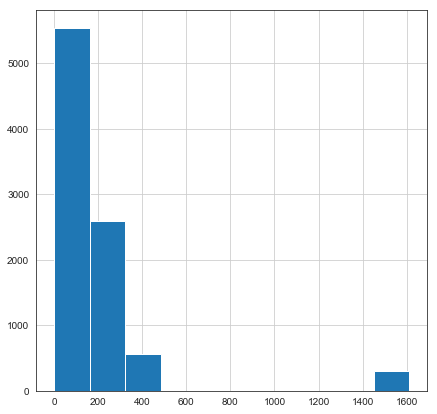

In [185]:
combined_score_hist['ELEVATION'].hist(figsize = (7,7))

Mile high stadium is really the only stadium that is close to affecting breathing levels, so we'll make a column to describe this. 

In [186]:
conditions = [(combined_score_hist['ELEVATION'] >= 1000)]

choices = ['difficult']

combined_score_hist['breathing_cond'] = np.select(conditions, choices, default='normal')
combined_score_hist['breathing_cond'].value_counts()

normal       8875
difficult     306
Name: breathing_cond, dtype: int64

### Add a variable for games that are division games

These games tend to be long dated rivalries as teams play twice a year and only one team from a 4 team division will make it into the post season (excluding the wildcard qualification). Anecdotally, these types of games tend to be closer matchups than one would expect, so it's at least worth flagging these. 

In [187]:
nfl_teams_short = nfl_teams[['team_id', 'team_division', 'team_division_pre2002']]
nfl_teams_short = nfl_teams_short.groupby(['team_id']).ffill().drop_duplicates()
nfl_teams_short['team_id'].value_counts()

TEN    2
IND    2
ARI    2
OAK    2
LAR    1
KC     1
WAS    1
DAL    1
MIN    1
PIT    1
NE     1
CIN    1
BUF    1
PHI    1
LAC    1
SF     1
BAL    1
CLE    1
CHI    1
HOU    1
DEN    1
NO     1
GB     1
JAX    1
TB     1
DET    1
SEA    1
ATL    1
MIA    1
NYG    1
NYJ    1
CAR    1
Name: team_id, dtype: int64

There are some teams that changed divisions multiple times due to the team moving, but our data is only split into the pre-2002 and post-2002 era.

In [188]:
nfl_teams_short

,team_id,team_division,team_division_pre2002
0,ARI,NFC West,NFC West
1,ARI,NFC West,NFC East
3,ATL,NFC South,NFC West
4,BAL,AFC North,AFC Central
5,BUF,AFC East,AFC East
6,CAR,NFC South,NFC West
7,CHI,NFC North,NFC Central
8,CIN,AFC North,AFC Central
9,CLE,AFC North,AFC Central
10,DAL,NFC East,NFC East


This took care of most of the divisions, so we can look them up, but the movement of teams still leaves some outcomes that need to be adjusted (eg. ARI for a team that is no longer around). 

In [189]:
nfl_teams_short.drop([0, 15, 30, 37], inplace = True)

In [190]:
nfl_teams_short.set_index('team_id', inplace = True)
nfl_teams_short

,team_division,team_division_pre2002
team_id,,
ARI,NFC West,NFC East
ATL,NFC South,NFC West
BAL,AFC North,AFC Central
BUF,AFC East,AFC East
CAR,NFC South,NFC West
CHI,NFC North,NFC Central
CIN,AFC North,AFC Central
CLE,AFC North,AFC Central
DAL,NFC East,NFC East


In [191]:
# Simple function to make the list comprehension easier to read
def find_division(df, team, year):
    if int(year) < 2002: 
        div = df.loc[team,'team_division_pre2002']
    else: 
        div = df.loc[team,'team_division']
    return div 

combined_score_hist['home_division'] = [find_division(nfl_teams_short, team, year) for team, year in 
                                        zip(combined_score_hist['team_home'], combined_score_hist['schedule_season'])]


combined_score_hist['away_division'] = [find_division(nfl_teams_short, team, year) for team, year in 
                                        zip(combined_score_hist['team_away'], combined_score_hist['schedule_season'])]


combined_score_hist['rivalry'] = ['Y' if h == a else 'N' for h, a in 
                                  zip(combined_score_hist['home_division'], combined_score_hist['away_division'])]

combined_score_hist['rivalry'].value_counts()

N    5245
Y    3936
Name: rivalry, dtype: int64

In [192]:
# To reduce the size of the dataset, we can eliminate the division names 
combined_score_hist.drop(['home_division', 'away_division', 'stadium_name','stadium','ELEVATION'], axis = 1, inplace = True)

In [193]:
combined_score_hist.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,...,score_away,stadium_neutral,stadium_type,conditions,home_last3_scored,home_last3_forfeited,away_last3_scored,away_last3_forfeited,breathing_cond,rivalry
0,1980-09-07,1980,1,BUF,MIA,MIA,-3.0,35.0,64.0,8.0,...,7.0,False,outdoor,normal,NaN,NaN,NaN,NaN,normal,Y
1,1980-09-07,1980,1,CIN,TB,TB,-1.0,34.0,72.0,9.0,...,17.0,False,outdoor,normal,NaN,NaN,NaN,NaN,normal,N
2,1980-09-07,1980,1,GB,CHI,CHI,-6.0,35.0,65.0,5.0,...,6.0,False,outdoor,good,NaN,NaN,NaN,NaN,normal,Y
3,1980-09-07,1980,1,KC,OAK,KC,-3.0,42.0,82.0,10.0,...,27.0,False,outdoor,normal,NaN,NaN,NaN,NaN,normal,Y
4,1980-09-07,1980,1,LAR,DET,LAR,-9.0,38.0,66.0,11.0,...,41.0,False,outdoor,normal,NaN,NaN,NaN,NaN,normal,N


### Additional Dataset: Elo Ratings from FiveThirtyEight on NFL teams

This will help us get an idea of the relative strengths of teams outside of the scores in recent games. This is a fun description of the methodology where they admit its limitations, but this data supplements what we have available and is worth trying in our model as they consider additional elements like strength of schedule for a team. 

https://fivethirtyeight.com/features/introducing-nfl-elo-ratings/

In [194]:
#nfl_elo_path = 'C:\\Users\\Pete Russell\\Desktop\\I526_AML_FA18\\Final Project\\nfl_elo_test.csv'

nfl_elo = pd.read_csv('../nfl-scores-and-betting-data/nfl_elo.csv')

nfl_elo['date'] = pd.to_datetime(nfl_elo['date'])
nfl_elo.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,score1,score2
0,1920-09-26,1920,0,NaN,RII,STP,1503.947,1300.000,0.824651,0.175349,1516.108,1287.838,48.0,0.0
1,1920-10-03,1920,0,NaN,BFF,WBU,1478.004,1300.000,0.802000,0.198000,1489.757,1288.247,32.0,6.0
2,1920-10-03,1920,0,NaN,CBD,PTQ,1504.688,1300.000,0.825267,0.174733,1516.803,1287.885,48.0,0.0
3,1920-10-03,1920,0,NaN,CHI,MUT,1368.333,1300.000,0.682986,0.317014,1386.533,1281.800,20.0,0.0
4,1920-10-03,1920,0,NaN,RII,MUN,1516.108,1478.004,0.644171,0.355829,1542.135,1451.977,45.0,0.0


Merge this data into our main dataset...

In [195]:
nfl_elo_small = nfl_elo[['date', 'team1', 'team2', 'elo1_pre','elo2_pre']]

elo_merge = combined_score_hist.merge(nfl_elo_small, how = 'left', left_on = ['schedule_date', 'team_home'], right_on = ['date','team1'])
elo_merge.drop(['date','team1', 'team2'], axis = 1, inplace = True)
elo_merge['diff'] = elo_merge['elo1_pre'] - elo_merge['elo2_pre']
elo_merge.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,...,conditions,home_last3_scored,home_last3_forfeited,away_last3_scored,away_last3_forfeited,breathing_cond,rivalry,elo1_pre,elo2_pre,diff
0,1980-09-07,1980,1,BUF,MIA,MIA,-3.0,35.0,64.0,8.0,...,normal,NaN,NaN,NaN,NaN,normal,Y,1465.161,1546.464,-81.303
1,1980-09-07,1980,1,CIN,TB,TB,-1.0,34.0,72.0,9.0,...,normal,NaN,NaN,NaN,NaN,normal,N,1470.732,1460.770,9.962
2,1980-09-07,1980,1,GB,CHI,CHI,-6.0,35.0,65.0,5.0,...,good,NaN,NaN,NaN,NaN,normal,Y,1428.338,1516.573,-88.235
3,1980-09-07,1980,1,KC,OAK,KC,-3.0,42.0,82.0,10.0,...,normal,NaN,NaN,NaN,NaN,normal,Y,1471.194,1546.315,-75.121
4,1980-09-07,1980,1,LAR,DET,LAR,-9.0,38.0,66.0,11.0,...,normal,NaN,NaN,NaN,NaN,normal,N,1536.751,1380.659,156.092


For the Elo ratings, they say each team is benchmarked against 1500, so we would expect the difference between two teams to be hovered around zero, which it appears to be. 

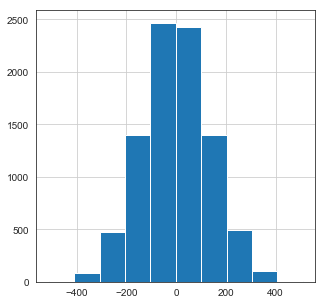

In [196]:
elo_merge['diff'].hist(figsize = (5,5))

#### Dataset is prepped and ready for testing!

# Create Target Variable
**This creates the target variable of what we will be calculating. We are baseing this on the home team and how the differential between the scores is. Also the target will the column favorite beat the spread by. **

In [197]:
#y=nfl_scores["score_home"]-nfl_scores["score_away"]


In [198]:
# Function determines if home or away team is favorite and returns how much the favorite won by
def calc_favorite_won_by (row):
    # Favored team played at home
    if re.search(row['team_favorite_id'], row['team_home'], re.IGNORECASE):
        return row['score_home']-row['score_away']
    else:
        return row['score_away']-row['score_home']

# Function determines if home or away team is favorite and returns how much the favorite beat spread by
def calc_favorite_beat_spread_by (row):
    return row['spread_favorite']+row['favorite_won_by']    
    
# Populate new columns with how much the favorite won by and how much the favorite beat spread by
nfl_scores['favorite_won_by']=nfl_scores.apply(lambda row: calc_favorite_won_by(row),axis=1)
nfl_scores['favorite_beat_spread_by']=nfl_scores.apply(lambda row: calc_favorite_beat_spread_by(row),axis=1)
y=nfl_scores['favorite_beat_spread_by']
nfl_scores.head()

,schedule_date,schedule_season,schedule_week,team_home,team_away,stadium,team_favorite_id,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,score_home,score_away,stadium_neutral,favorite_won_by,favorite_beat_spread_by
2734,1980-09-07,1980,1,BUF,MIA,Ralph Wilson Stadium,MIA,-3.0,35.0,64.0,8.0,17.0,7.0,False,-10.0,-13.0
2735,1980-09-07,1980,1,CIN,TB,Cinergy Field,TB,-1.0,34.0,72.0,9.0,12.0,17.0,False,5.0,4.0
2736,1980-09-07,1980,1,GB,CHI,Lambeau Field,CHI,-6.0,35.0,65.0,5.0,12.0,6.0,False,-6.0,-12.0
2737,1980-09-07,1980,1,KC,OAK,Arrowhead Stadium,KC,-3.0,42.0,82.0,10.0,14.0,27.0,False,-13.0,-16.0
2738,1980-09-07,1980,1,LAR,DET,Anaheim Stadium,LAR,-9.0,38.0,66.0,11.0,20.0,41.0,False,-21.0,-30.0


# Machine Learning

In [76]:
X_train, X_other, y_train, y_other=train_test_split(elo_merge,y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val=train_test_split(X_other,y_other, test_size=0.5, random_state=42)

## Numerical and Categorical Pipelines

* Identify Numerical and categorical attributes of the new data set

In [77]:
num_attribs=[ 
        'spread_favorite', 'over_under_line',
       'weather_temperature', 'weather_wind_mph', 'score_home', 'score_away','elo1_pre', 'elo2_pre', 'diff',
        'home_last3_scored',
       'home_last3_forfeited', 'away_last3_scored', 'away_last3_forfeited']
cat_attribs=['schedule_season','schedule_week','team_home', 'team_away','team_favorite_id','stadium_neutral',
            'breathing_cond', 'rivalry','stadium_type']


* Create Pipeline for the numerical features. This pipeline will include a dataframe selector for the numerical attributes  and will also impute the NA values and standardize the data
* Create a pipeline for categorical values that will select the categorical attributes from the dataframe, impute the NA values and also perform OneHotEncoding
* Create a union of the two pipelines

In [ ]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])


## Dummy Regressor
This is the baseline where all testing will be done against

In [79]:
model = DummyRegressor(strategy='mean')
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=42)
baseline_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
baseline_train_score = np.sqrt(-baseline_scores.mean())

start = time()
model.fit(X_train, y_train)
baseline_train_predict = model.fit(X_train, y_train)
train_time_bs = np.round(time()-start,3)

start = time()
baseline_test_predict = model.predict(X_val)
baseline_test_score = np.sqrt(mean_squared_error(y_val, baseline_test_predict))
test_time = np.round(time()-start,3)

results = pd.DataFrame(columns=["ExpID", "Train Accuracy (Mean)", "Test Accuracy", "p-value", "Train Time(s)", "Test Time(s)", "Experiment description"])

results.loc[0] = ['Baseline', "--", baseline_test_score, "--", train_time_bs, test_time, "--"]

In [125]:
# A Function to execute the grid search and record the results.

def ConductGridSearch(X_train, y_train, X_test, y_test, i=0, prefix=''):
    # Create a list of classifiers for our grid search experiment
    classifiers = [
        ('Linear Regression', LinearRegression(n_jobs=-1)),
        ('K-Nearest Neighbors', KNeighborsClassifier()),
        ('Logistic Regression', LogisticRegression()),
        ('Stochastic GD', SGDRegressor(max_iter=1000)),
        ('RandomForest', RandomForestClassifier()),
    ]

    # Arrange grid search parameters for each classifier
    params_grid = {
        'Linear Regression': {
            'normalize': (True, False)
        },
        'K-Nearest Neighbors': {
            'n_neighbors': (7, 8, 11,13,15,17,20,22),
            'weights':('distance','uniform'),
            'p': (1,2),
        },
        'Logistic Regression' : {
            'penalty': ('l1', 'l2'),     
            'C': (10, 1, 0.1, 0.01,.001),
        },
        'Stochastic GD': {
            'loss': ('squared_loss', 'huber', 'squared_epsilon_insensitive'),
            'penalty': ('l1', 'l2', 'elasticnet'),
            'tol': (0.0001, 0.00001, 0.0000001), 
            'alpha': (0.1, 0.01, 0.001, 0.0001), 
        },
        'RandomForest':  {
            'max_depth': [9, 15, 22, 26, 30],
            'max_features': [1, 3, 5],
            'min_samples_split': [5, 10, 15],
            'min_samples_leaf': [3, 5, 10],
            'bootstrap': [False],
            'n_estimators':[20, 80, 150, 200, 300]},
    }
    
    for (name, classifier) in classifiers:
        i += 1
        # Print classifier and parameters
        print('****** START',prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline
        full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("predictor", classifier)
        ])
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
            
        grid_search = GridSearchCV(full_pipeline_with_predictor,params, scoring='neg_mean_squared_error',cv=5, verbose=1)
        grid_search.fit(X_train, y_train)
                
        # Best estimator score
        best_train = pct(grid_search.best_score_)

        # Best estimator fitting time
        start = time()
        grid_search.best_estimator_.fit(X_train, y_train)
        train_time = round(time() - start, 4)

        # Best estimator prediction time
        start = time()
        best_test_accuracy = pct(grid_search.best_estimator_.score(X_test, y_test))
        test_time = round(time() - start, 4)

        # Generate 30 training accuracy scores with the best estimator and 30-split CV
        best_train_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv)
        best_train_accuracy = pct(best_train_scores.mean())

        # Conduct t-test with baseline logit (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(baseline_scores, best_train_scores)
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results.loc[i] = [prefix+name, best_train_accuracy, best_test_accuracy, round(p_value,3), train_time, test_time, json.dumps(param_dump)]

## GridSearchCV

In [126]:
#results = pd.DataFrame(columns=["ExpID", "Train Accuracy (Mean)", "Test Accuracy", "p-value", "Train Time(s)", "Test Time(s)", "Experiment description"])

ConductGridSearch(X_train, y_train, X_test, y_test, 0, "Best Model:")

****** START Best Model: Linear Regression *****
Parameters:
	normalize: (True, False)
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.8s finished


Best Parameters:
	predictor__normalize: False
****** FINISH Best Model: Linear Regression  *****

****** START Best Model: K-Nearest Neighbors *****
Parameters:
	n_neighbors: (7, 8, 11, 13, 15, 17, 20, 22)
	p: (1, 2)
	weights: ('distance', 'uniform')
Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\model_selection\_split.py:626: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 77.6min finished


Best Parameters:
	predictor__n_neighbors: 20
	predictor__p: 2
	predictor__weights: distance
****** FINISH Best Model: K-Nearest Neighbors  *****

****** START Best Model: Logistic Regression *****
Parameters:
	C: (10, 1, 0.1, 0.01, 0.001)
	penalty: ('l1', 'l2')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\model_selection\_split.py:626: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\logistic.py

Best Parameters:
	predictor__C: 0.001
	predictor__penalty: l1
****** FINISH Best Model: Logistic Regression  *****

****** START Best Model: Stochastic GD *****
Parameters:
	alpha: (0.1, 0.01, 0.001, 0.0001)
	loss: ('squared_loss', 'huber', 'squared_epsilon_insensitive')
	penalty: ('l1', 'l2', 'elasticnet')
	tol: (0.0001, 1e-05, 1e-07)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning:

Maximum number of iteration reached before co

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\shiva\AppDa

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\shiva\AppDa

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\shiva\AppDa

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

C:\Users\shiva\AppDa

Best Parameters:
	predictor__alpha: 0.1
	predictor__loss: squared_loss
	predictor__penalty: elasticnet
	predictor__tol: 0.0001
****** FINISH Best Model: Stochastic GD  *****

****** START Best Model: RandomForest *****
Parameters:
	bootstrap: [False]
	max_depth: [9, 15, 22, 26, 30]
	max_features: [1, 3, 5]
	min_samples_leaf: [3, 5, 10]
	min_samples_split: [5, 10, 15]
	n_estimators: [20, 80, 150, 200, 300]
Fitting 5 folds for each of 675 candidates, totalling 3375 fits


C:\Users\shiva\AppData\Local\conda\conda\envs\AML\lib\site-packages\sklearn\model_selection\_split.py:626: Warning:

The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3375 out of 3375 | elapsed: 153.0min finished


Best Parameters:
	predictor__bootstrap: False
	predictor__max_depth: 30
	predictor__max_features: 5
	predictor__min_samples_leaf: 3
	predictor__min_samples_split: 15
	predictor__n_estimators: 200
****** FINISH Best Model: RandomForest  *****



# Results
The Results table is showing the results of the gridsearch. The gridsearch found that the Logistic Regression was the best at predicting a value just 2.3 points away from its target. However, Logistic Regression did have a training time that was on the longer side. That means that for example the model is just 2.3 points from predicting if the game will beat the spread. That is incredible close and much better than the baseline was about 14 points. K nearest neighbors also gave a similar result. The values proved to be more significant than the baseline which is 100% accurate.  


**BEST HYPERPARAMETERS**
1. Linear Regression: Best Parameters:
	predictor__normalize: False
+ KNN: Best Parameters:
	predictor__n_neighbors: 20
	predictor__p: 2
	predictor__weights: distance
+ Logistic Regression: Best Parameters:
	predictor__C: 0.001
	predictor__penalty: l1
+ Stochastic GD: Best Parameters:
	predictor__alpha: 0.1
	predictor__loss: squared_loss
	predictor__penalty: elasticnet
	predictor__tol: 0.0001
+ Random Forest: Best Parameters:
	predictor__bootstrap: False
	predictor__max_depth: 30
	predictor__max_features: 5
	predictor__min_samples_leaf: 3
	predictor__min_samples_split: 15
	predictor__n_estimators: 200

In [128]:
results

,ExpID,Train Accuracy (Mean),Test Accuracy,p-value,Train Time(s),Test Time(s),Experiment description
1,Best Model:Linear Regression,-2.182928e+21,13.6,0.261,0.4840,0.0140,"[[""predictor__normalize"", false]]"
2,Best Model:K-Nearest Neighbors,2.600000e+00,2.4,0.000,0.2154,2.3248,"[[""predictor__n_neighbors"", 20], [""predictor__..."
3,Best Model:Logistic Regression,2.700000e+00,2.3,0.000,2.5003,0.0100,"[[""predictor__C"", 0.001], [""predictor__penalty..."
4,Best Model:Stochastic GD,8.000000e+00,12.6,0.000,0.3690,0.0060,"[[""predictor__alpha"", 0.1], [""predictor__loss""..."
5,Best Model:RandomForest,3.400000e+00,3.2,0.000,8.6088,0.6082,"[[""predictor__bootstrap"", false], [""predictor_..."
